# Imports

In [1]:
import os
import cv2
import glob
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from minisom import MiniSom
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications.vgg16 import VGG16

# Dataset Summary

**Name:** DFC15_multilabel

In [2]:
BASE_DATA_DIR = "/home/jovyan/work/data/"
DATASET_DIR = "DFC15_multilabel"
FULL_DATASET_DIR = os.path.join(BASE_DATA_DIR, DATASET_DIR)
TRAIN_IMAGES_PATH = os.path.join(FULL_DATASET_DIR, "images_tr")
TEST_IMAGES_PATH = os.path.join(FULL_DATASET_DIR, "images_test")

print(f"Dataset in {FULL_DATASET_DIR}")
print(f"Contents of dataset dir is {os.listdir(FULL_DATASET_DIR)}")

Dataset in /home/jovyan/work/data/DFC15_multilabel
Contents of dataset dir is ['images_tr', 'images_test', 'multilabel.csv', 'multilabel.mat']


In [3]:
multilabel_df = pd.read_csv(os.path.join(FULL_DATASET_DIR, "multilabel.csv"))
multilabel_df.head()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car
0,1,1,1,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0
3,4,1,1,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0


In [4]:
print("Total number of samples: ", multilabel_df.shape[0])
print("Total number of features: ", multilabel_df.shape[1] - 1)

Total number of samples:  3342
Total number of features:  8


In [5]:
multilabel_df.describe()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car
count,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000
mean,1671.500000,0.937463,0.298624,0.565829,0.324955,0.299521,0.077199,0.080790,0.210952
std,964.896627,0.242165,0.457723,0.495722,0.468428,0.458117,0.266947,0.272553,0.408045
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,836.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1671.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2506.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,3342.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
multilabel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   image\label  3342 non-null   int64
 1   impervious   3342 non-null   int64
 2   water        3342 non-null   int64
 3   clutter      3342 non-null   int64
 4   vegetation   3342 non-null   int64
 5   building     3342 non-null   int64
 6   tree         3342 non-null   int64
 7   boat         3342 non-null   int64
 8   car          3342 non-null   int64
dtypes: int64(9)
memory usage: 235.1 KB


## Sample Distributions

In [7]:
print("Number of images in train set:", len(glob.glob(os.path.join(TRAIN_IMAGES_PATH, "*.png"))))
print("Number of images in test set:", len(glob.glob(os.path.join(TEST_IMAGES_PATH, "*.png"))))

Number of images in train set: 2673
Number of images in test set: 669


In [8]:
multilabel_df["in_train"] = np.zeros((multilabel_df.shape[0],), dtype=int)

In [9]:
for image_file in glob.glob(os.path.join(TRAIN_IMAGES_PATH, "*.png")):
    basename = os.path.basename(image_file)
    image_id = os.path.splitext(basename)[0]
    
    multilabel_df.loc[multilabel_df["image\\label"] == int(image_id), "in_train"] = 1

In [10]:
print("Number of images in train set:", multilabel_df["in_train"].sum())
print("Number of images in test set:", (multilabel_df["in_train"] == 0).sum())

Number of images in train set: 2673
Number of images in test set: 669


## Label Analysis

In [11]:
multilabel_df["total_label_count"] = multilabel_df.drop(["image\\label", "in_train"], axis=1).sum(axis=1)

In [12]:
multilabel_df.head()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car,in_train,total_label_count
0,1,1,1,0,0,0,0,0,0,1,2
1,2,1,1,0,0,0,0,0,0,1,2
2,3,1,1,0,0,0,0,0,0,0,2
3,4,1,1,0,0,0,0,0,0,1,2
4,5,1,1,0,0,0,0,0,0,1,2


### Label Distributions to Samples

In [13]:
multilabel_df["total_label_count"].describe()

count    3342.000000
mean        2.795332
std         0.948227
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: total_label_count, dtype: float64

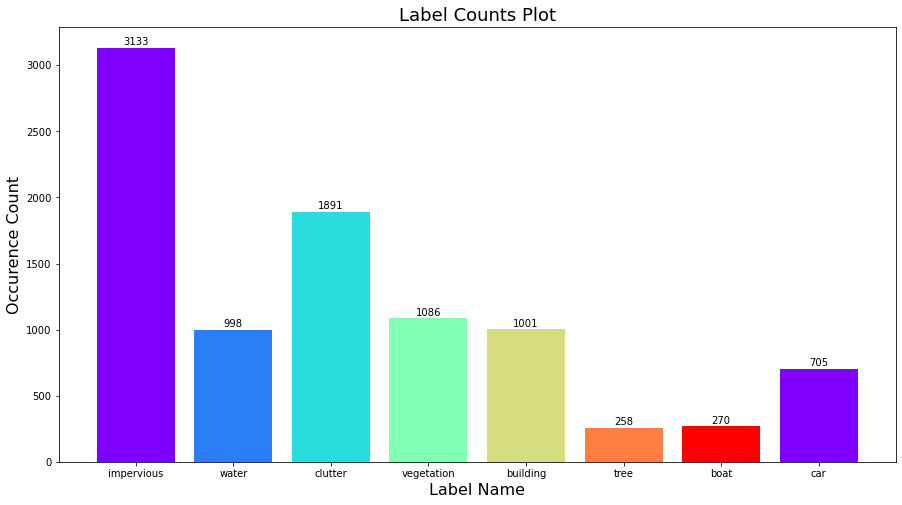

In [14]:
plt_data = multilabel_df.drop(["image\\label", "total_label_count", "in_train"], axis=1).sum(axis=0)

fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(plt_data.index, plt_data.values, color=matplotlib.cm.rainbow(np.linspace(0, 1, 7)))

rects = ax.patches
labels = plt_data.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
plt.title("Label Counts Plot", fontsize=18)
plt.xlabel("Label Name", fontsize=16)
plt.ylabel("Occurence Count", fontsize=16)

plt.show()

### Label Distributions Over Train and Test Sets

In [15]:
multilabel_df[multilabel_df["in_train"] == 1].describe()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car,in_train,total_label_count
count,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,2673.000000
mean,1663.259633,0.941264,0.295922,0.564160,0.324355,0.298167,0.075196,0.080808,0.207258,1.0,2.787131
std,967.507156,0.235173,0.456542,0.495959,0.468221,0.457539,0.263757,0.272591,0.405418,0.0,0.943755
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000
25%,819.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000
50%,1662.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000
75%,2503.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,3.000000
max,3342.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,6.000000


In [16]:
multilabel_df[multilabel_df["in_train"] == 0].describe()

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car,in_train,total_label_count
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.0,669.000000
mean,1704.424514,0.922272,0.309417,0.572496,0.327354,0.304933,0.085202,0.080717,0.225710,0.0,2.828102
std,954.402170,0.267943,0.462599,0.495087,0.469599,0.460723,0.279391,0.272605,0.418362,0.0,0.965910
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000
25%,891.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000
50%,1714.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000
75%,2521.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,4.000000
max,3324.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,6.000000


## Label Correlations

In [17]:
just_labels_df = multilabel_df.drop(["image\\label", "total_label_count", "in_train"], axis=1)
just_labels_df.corr()

,impervious,water,clutter,vegetation,building,tree,boat,car
impervious,1.000000,-0.301318,-0.009329,0.015609,0.152704,-0.129018,-0.367842,0.133546
water,-0.301318,1.000000,-0.267381,-0.105124,-0.201152,-0.068699,0.425553,-0.159502
clutter,-0.009329,-0.267381,1.000000,-0.486573,-0.426228,-0.296263,-0.048236,-0.246978
vegetation,0.015609,-0.105124,-0.486573,1.000000,0.409673,0.412089,-0.168181,0.291117
building,0.152704,-0.201152,-0.426228,0.409673,1.000000,0.104566,-0.054825,0.523324
tree,-0.129018,-0.068699,-0.296263,0.412089,0.104566,1.000000,-0.085748,0.023561
boat,-0.367842,0.425553,-0.048236,-0.168181,-0.054825,-0.085748,1.000000,-0.005267
car,0.133546,-0.159502,-0.246978,0.291117,0.523324,0.023561,-0.005267,1.000000


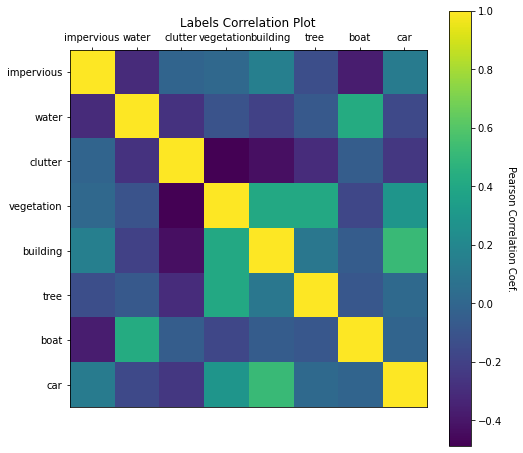

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.xaxis.tick_top()
im = ax.imshow(just_labels_df.corr())
plt.xticks(ticks=np.arange(just_labels_df.shape[1]), labels=just_labels_df.columns)
plt.yticks(ticks=np.arange(just_labels_df.shape[1]), labels=just_labels_df.columns)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Pearson Correlation Coef.", rotation=-90, va="bottom")

plt.title("Labels Correlation Plot")

plt.show()

## Subset Analysis

In [19]:
total_unique_subsets = multilabel_df.drop(["image\\label", "in_train", "total_label_count"], axis=1).drop_duplicates().values

### Total Number of Unique Subsets

In [20]:
len(total_unique_subsets)
print(f"Number of unique subsets in whole dataset: {len(total_unique_subsets)}")

Number of unique subsets in whole dataset: 65


### Total Number of Unique Subsets in Train Set

In [21]:
training_subsets = multilabel_df[multilabel_df["in_train"] == 1] \
    .drop(["image\\label", "in_train", "total_label_count"], axis=1).drop_duplicates().values

In [22]:
print(f"Number of unique subsets in train set: {len(training_subsets)}")

Number of unique subsets in train set: 64


### Total Number of Subsets Do Not Exist in Train Set

In [23]:
print(f"Number of subsets which do not exist in train set: \
    {len(set(map(tuple, total_unique_subsets)) - set(map(tuple, training_subsets)))}")

Number of subsets which do not exist in train set:     1


### Total Number of Unique Subsets in Test Set

In [24]:
test_subsets = multilabel_df[multilabel_df["in_train"] == 0] \
    .drop(["image\\label", "in_train", "total_label_count"], axis=1).drop_duplicates().values

In [25]:
print(f"Number of unique subsets in test set: {len(test_subsets)}")

Number of unique subsets in test set: 50


### Total Number of Subsets Do Not Exist in Test Set

In [26]:
print(f"Number of subsets which do not exist in test set: \
    {len(set(map(tuple, total_unique_subsets)) - set(map(tuple, test_subsets)))}")

Number of subsets which do not exist in test set:     15


## Assigning Subsets to the Samples

In [27]:
multilabel_df["subset"] = multilabel_df.drop(["image\\label", "in_train", "total_label_count"], axis=1) \
    .apply(lambda x: (x.values.reshape(1, -1) == total_unique_subsets).all(axis=1).nonzero()[0][0], axis=1)

In [28]:
multilabel_df.sample(10)

,image\label,impervious,water,clutter,vegetation,building,tree,boat,car,in_train,total_label_count,subset
201,202,1,0,1,0,0,0,0,0,0,2,6
1547,1548,1,1,0,0,0,0,0,0,1,2,0
246,247,1,0,1,0,0,0,0,0,1,2,6
1675,1676,1,0,0,0,1,0,0,0,1,2,7
48,49,1,0,1,0,0,0,0,0,1,2,6
651,652,1,0,1,0,0,0,0,0,1,2,6
654,655,1,0,1,0,0,0,0,0,1,2,6
2329,2330,1,1,1,0,0,0,1,0,1,4,36
2676,2677,1,0,1,1,1,1,0,1,1,6,49
1047,1048,1,0,1,0,0,0,0,0,1,2,6


### Subset Distribution in the Dataset

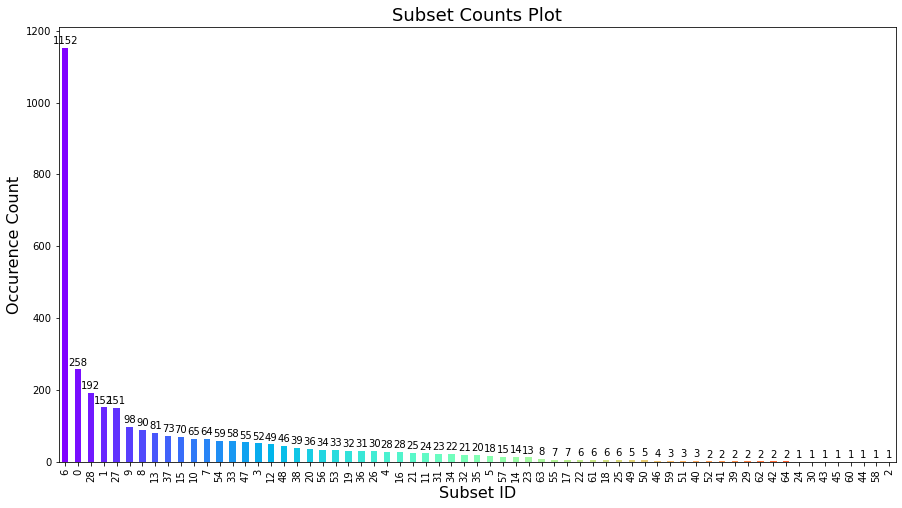

In [29]:
subset_value_counts = multilabel_df["subset"].value_counts()

fig, ax = plt.subplots(figsize=(15, 8))

#ax.bar(subset_val_counts.index, subset_val_counts.values, , color=matplotlib.cm.rainbow(np.linspace(0, 1, len(total_unique_subsets))))
subset_value_counts.plot.bar(ax=ax, color=matplotlib.cm.rainbow(np.linspace(0, 1, len(total_unique_subsets))))

rects = ax.patches
labels = subset_value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
plt.title("Subset Counts Plot", fontsize=18)
plt.xlabel("Subset ID", fontsize=16)
plt.ylabel("Occurence Count", fontsize=16)

plt.show()

### Subset Distribution in Train Set

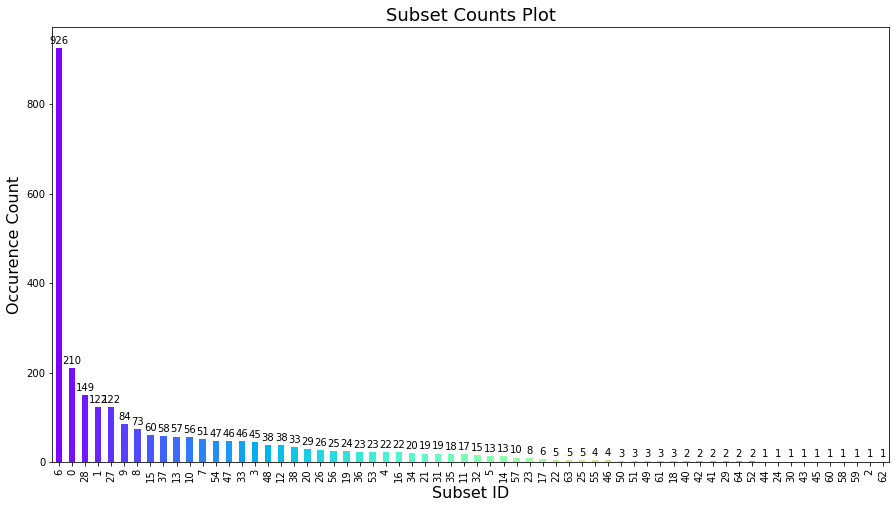

In [30]:
subset_value_counts = multilabel_df[multilabel_df["in_train"] == 1]["subset"].value_counts()

fig, ax = plt.subplots(figsize=(15, 8))

#ax.bar(subset_val_counts.index, subset_val_counts.values, , color=matplotlib.cm.rainbow(np.linspace(0, 1, len(total_unique_subsets))))
subset_value_counts.plot.bar(ax=ax, color=matplotlib.cm.rainbow(np.linspace(0, 1, len(total_unique_subsets))))

rects = ax.patches
labels = subset_value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
plt.title("Subset Counts Plot", fontsize=18)
plt.xlabel("Subset ID", fontsize=16)
plt.ylabel("Occurence Count", fontsize=16)

plt.show()

### Subset Distribution in Test Set

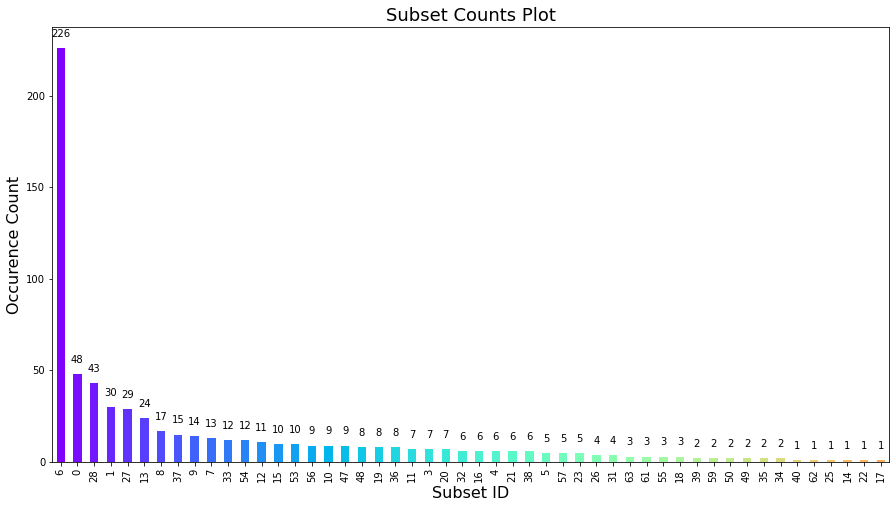

In [31]:
subset_value_counts = multilabel_df[multilabel_df["in_train"] == 0]["subset"].value_counts()

fig, ax = plt.subplots(figsize=(15, 8))

subset_value_counts.plot.bar(ax=ax, color=matplotlib.cm.rainbow(np.linspace(0, 1, len(total_unique_subsets))))
rects = ax.patches
labels = subset_value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom")
plt.title("Subset Counts Plot", fontsize=18)
plt.xlabel("Subset ID", fontsize=16)
plt.ylabel("Occurence Count", fontsize=16)

plt.show()

# Feature Extraction

In [32]:
vgg16_network = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=(224, 224, 3),
                      pooling=None)

In [33]:
resized_raw_train_images = list()
resized_raw_train_labels = list()

for raw_image_file in glob.glob(os.path.join(TRAIN_IMAGES_PATH, "*.png")):
    raw_img = cv2.imread(raw_image_file)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    
    resized_raw_img = cv2.resize(raw_img, (224, 224))
    
    resized_raw_train_images.append(resized_raw_img)
    resized_raw_train_labels.append(os.path.basename(raw_image_file).split(".")[0])

In [34]:
preprediction_images = np.array(resized_raw_train_images)

In [35]:
preprediction_images.shape

(2673, 224, 224, 3)

In [36]:
postprediction_features = vgg16_network.predict(preprediction_images)

In [37]:
postprediction_features.shape

(2673, 7, 7, 512)

In [38]:
flattened_postprediction_features = postprediction_features.reshape(postprediction_features.shape[0], -1)

## CITF Creation Without Word Embedding

In [39]:
citf_vector = list()
citf_vector_train_test = list()
for flattened_postprediction_feature, image_id in zip(flattened_postprediction_features, resized_raw_train_labels):
    filtered_idx = multilabel_df["image\\label"] == int(image_id)
    tags = multilabel_df[filtered_idx].drop(["image\\label", "in_train", "total_label_count", "subset"], axis=1).values[0]
    
    citf_vector.append(np.concatenate((flattened_postprediction_feature, tags)))
    citf_vector_train_test.append(np.concatenate((flattened_postprediction_feature, np.zeros_like(tags))))

citf_vector = np.array(citf_vector)
citf_vector_train_test = np.array(citf_vector_train_test)

In [40]:
flattened_postprediction_features.shape

(2673, 25088)

In [41]:
citf_vector.shape

(2673, 25096)

# Clustering

In [42]:
som = MiniSom(16, 16, citf_vector.shape[1],
              sigma=3.0,
              learning_rate=0.7,
              topology="hexagonal",
              activation_distance="cosine")

In [43]:
som.random_weights_init(citf_vector)

In [44]:
som.train_random(citf_vector, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1131.8110271245432


# Scoring

## With Train Set
**Threshold = 0.5**

In [45]:
y_pred = list()
for x in citf_vector_train_test:
    winner_coords = som.winner(x)
    y_pred.append(som.get_weights()[winner_coords][-8:])
y_pred = np.array(y_pred)

In [46]:
y_pred.shape

(2673, 8)

In [47]:
y_test = citf_vector[:, -8:]
y_test.shape

(2673, 8)

In [48]:
y_pred_tresholded = (y_pred >= 0.5).astype(int)

In [49]:
labels = multilabel_df.drop(["image\\label", "in_train", "total_label_count", "subset"], axis=1).columns
print(classification_report(y_test, y_pred_tresholded, target_names=labels))

              precision    recall  f1-score   support

  impervious       0.96      0.96      0.96      2516
       water       0.78      0.44      0.57       791
     clutter       0.82      0.83      0.83      1508
  vegetation       0.67      0.74      0.70       867
    building       0.86      0.53      0.65       797
        tree       0.70      0.15      0.25       201
        boat       0.70      0.38      0.50       216
         car       0.69      0.36      0.48       554

   micro avg       0.85      0.72      0.78      7450
   macro avg       0.77      0.55      0.62      7450
weighted avg       0.84      0.72      0.76      7450
 samples avg       0.85      0.76      0.79      7450



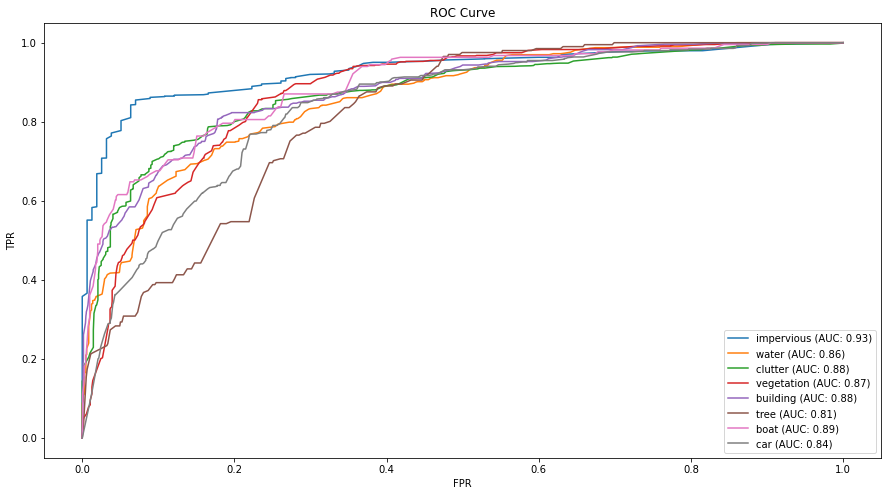

In [50]:
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(len(labels)):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    ax.plot(fpr, tpr, label=labels[i] + f" (AUC: {auc:.2f})")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

## With Test Set

**Threshold = 0.5**

In [51]:
resized_raw_test_images = list()
resized_raw_test_labels = list()

for raw_image_file in glob.glob(os.path.join(TEST_IMAGES_PATH, "*.png")):
    raw_img = cv2.imread(raw_image_file)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    
    resized_raw_img = cv2.resize(raw_img, (224, 224))
    
    resized_raw_test_images.append(resized_raw_img)
    resized_raw_test_labels.append(os.path.basename(raw_image_file).split(".")[0])

In [52]:
preprediction_images_test = np.array(resized_raw_test_images)

In [53]:
preprediction_images_test.shape

(669, 224, 224, 3)

In [54]:
postprediction_features_test = vgg16_network.predict(preprediction_images_test)

In [55]:
postprediction_features_test.shape

(669, 7, 7, 512)

In [56]:
flattened_postprediction_features_test = postprediction_features_test.reshape(postprediction_features_test.shape[0], -1)

In [57]:
citf_vector_test = list()
y_test = list()
y_test_subset = list()
for flattened_postprediction_feature, image_id in zip(flattened_postprediction_features_test, resized_raw_test_labels):
    filtered_idx = multilabel_df["image\\label"] == int(image_id)
    tags = multilabel_df[filtered_idx].drop(["image\\label", "in_train", "total_label_count", "subset"], axis=1).values[0]
    subset = multilabel_df[filtered_idx]["subset"].values[0]
    
    y_test.append(tags)
    y_test_subset.append(subset)
    
    citf_vector_test.append(np.concatenate((flattened_postprediction_feature, np.zeros_like(tags))))

citf_vector_test = np.array(citf_vector_test)
y_test = np.array(y_test)
y_test_subset = np.array(y_test_subset)

In [58]:
citf_vector_test[:, -8:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
y_pred = list()
for x in citf_vector_test:
    winner_coords = som.winner(x)
    y_pred.append(som.get_weights()[winner_coords][-8:])
y_pred = np.array(y_pred)

In [60]:
y_pred.shape

(669, 8)

In [61]:
y_test.shape

(669, 8)

In [62]:
y_test_subset.shape

(669,)

In [63]:
y_pred_tresholded = (y_pred >= 0.5).astype(int)

### Subset Results

In [64]:
y_pred_subset = list()
for x in y_pred_tresholded:
    if (x.reshape(1, -1) == total_unique_subsets).all(axis=1).any():
        y_pred_subset.append((x.reshape(1, -1) == total_unique_subsets).all(axis=1).nonzero()[0][0])
    else:
        y_pred_subset.append(-1)
y_pred_subset = np.array(y_pred_subset)

In [65]:
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
onehot_encoder.fit(y_test_subset.reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

In [66]:
y_pred_subset_ohencoded = onehot_encoder.transform(y_pred_subset.reshape(-1, 1))
y_test_subset_ohencoded = onehot_encoder.transform(y_test_subset.reshape(-1, 1))

In [67]:
#labels = multilabel_df.drop(["image\\label", "in_train", "total_label_count", "subset"], axis=1).columns
print(classification_report(y_test_subset_ohencoded, y_pred_subset_ohencoded))

              precision    recall  f1-score   support

           0       0.30      0.12      0.18        48
           1       0.30      0.23      0.26        30
           2       0.03      0.14      0.05         7
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         5
           5       0.74      0.92      0.82       226
           6       0.00      0.00      0.00        13
           7       0.21      0.35      0.27        17
           8       0.00      0.00      0.00        14
           9       0.08      0.67      0.14         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        24
          13       0.00      0.00      0.00         1
          14       0.13      0.30      0.18        10
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         1
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Multi-Label Results

In [68]:
labels = multilabel_df.drop(["image\\label", "in_train", "total_label_count", "subset"], axis=1).columns
print(classification_report(y_test, y_pred_tresholded, target_names=labels))

              precision    recall  f1-score   support

  impervious       0.95      0.97      0.96       617
       water       0.80      0.40      0.53       207
     clutter       0.80      0.81      0.80       383
  vegetation       0.64      0.70      0.67       219
    building       0.82      0.53      0.64       204
        tree       0.83      0.18      0.29        57
        boat       0.85      0.41      0.55        54
         car       0.72      0.37      0.49       151

   micro avg       0.84      0.71      0.77      1892
   macro avg       0.80      0.55      0.62      1892
weighted avg       0.83      0.71      0.75      1892
 samples avg       0.84      0.75      0.77      1892



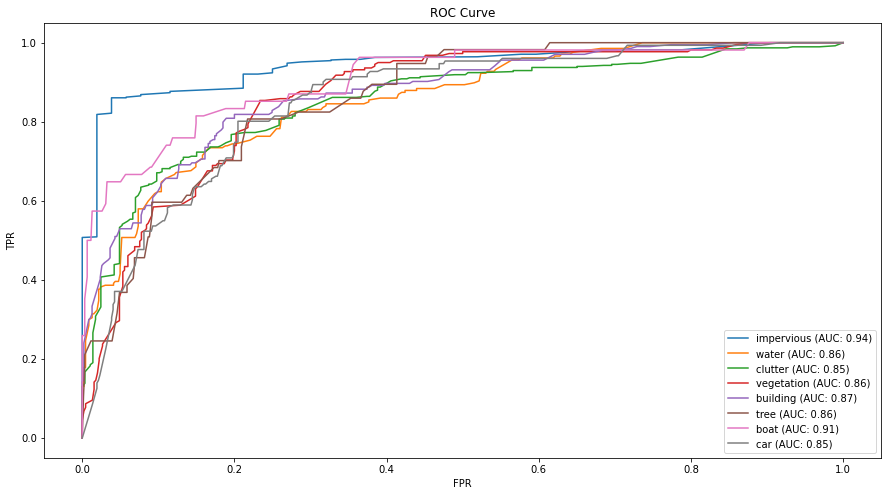

In [69]:
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(len(labels)):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    ax.plot(fpr, tpr, label=labels[i] + f" (AUC: {auc:.2f})")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()